In [1]:
# ⚠️ RESTART KERNEL FIRST! Then run this cell to initialize everything fresh

# Import required libraries
import re
import json
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import io

# Chess library - install if needed
try:
    import chess
    import chess.pgn
    import chess.svg
    print("✅ Chess library imported successfully")
except ImportError:
    print("Installing python-chess...")
    !pip install python-chess
    import chess
    import chess.pgn
    import chess.svg
    print("✅ Chess library installed and imported")

# For displaying SVG in Jupyter
try:
    from IPython.display import SVG, display
    print("✅ IPython display imported")
except ImportError:
    print("IPython not available - SVG display may not work")
    SVG = None
    display = print

# Chess piece values for material calculation - CUSTOM IMPLEMENTATION
PIECE_VALUES = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9,
    chess.KING: 0  # King has no material value in traditional count
}

def get_piece_value(piece_type: int) -> int:
    """Get the material value of a chess piece (CUSTOM - replaces chess.piece_type_value)"""
    return PIECE_VALUES.get(piece_type, 0)

def get_piece_name(piece_type: int) -> str:
    """Get the name of a chess piece"""
    piece_names = {
        chess.PAWN: 'pawn',
        chess.KNIGHT: 'knight', 
        chess.BISHOP: 'bishop',
        chess.ROOK: 'rook',
        chess.QUEEN: 'queen',
        chess.KING: 'king'
    }
    return piece_names.get(piece_type, 'piece')

print("✅ Custom piece value functions defined")

# Enhanced Chess Board Visualizer
class ChessBoardVisualizer:
    """Creates visual chess board representations"""
    
    def __init__(self):
        pass
    
    def create_board_svg(self, board: chess.Board, last_move=None, size=400) -> str:
        """Generate SVG representation of chess board"""
        try:
            if last_move:
                return chess.svg.board(board, lastmove=last_move, size=size)
            else:
                return chess.svg.board(board, size=size)
        except Exception as e:
            print(f"SVG generation failed: {e}")
            return self.create_ascii_board(board)
    
    def create_ascii_board(self, board: chess.Board) -> str:
        """Create ASCII representation of chess board"""
        return str(board)
    
    def display_board(self, board: chess.Board, last_move=None):
        """Display board in Jupyter notebook"""
        if SVG and display:
            try:
                svg_board = self.create_board_svg(board, last_move)
                display(SVG(svg_board))
            except Exception as e:
                print(f"SVG board display failed: {e}")
                print("Showing ASCII board instead:")
                print(self.create_ascii_board(board))
        else:
            print(self.create_ascii_board(board))

print("✅ ChessBoardVisualizer class defined")

# Enhanced Commentary Generator with Board Visualization
class VisualCommentaryGenerator:
    """Generates chess commentary with synchronized board positions"""
    
    def __init__(self):
        self.visualizer = ChessBoardVisualizer()
        
    def generate_move_commentary(self, move_num: int, move_san: str, board_before: chess.Board, 
                                board_after: chess.Board, move_obj: chess.Move, is_white_move: bool) -> str:
        """Generate commentary for a specific move"""
        
        player = "White" if is_white_move else "Black"
        move_description = f"{move_num}{'.' if is_white_move else '...'}{move_san}"
        
        # Basic move analysis
        is_capture = board_before.is_capture(move_obj)
        is_check = board_after.is_check()
        is_checkmate = board_after.is_checkmate()
        
        # Generate commentary based on move characteristics
        if is_checkmate:
            commentary = f"And that's checkmate! {move_description} ends the game. "
            commentary += f"Chat, that was beautiful execution by {player}. Like, you don't see sacrificial attacks like this often. "
            commentary += f"Absolute mastery of tactical motifs and king safety principles."
            
        elif is_check:
            commentary = f"{move_description} gives check! "
            commentary += f"This move puts immediate pressure on {('Black' if is_white_move else 'White')}'s king. "
            commentary += f"Chat, this is getting spicy. {player} is really turning up the heat here."
            
        elif is_capture:
            captured_piece = board_before.piece_at(move_obj.to_square)
            if captured_piece:
                piece_name = get_piece_name(captured_piece.piece_type)
                commentary = f"{move_description} captures the {piece_name}! "
                commentary += f"This is a significant material gain for {player}. "
                commentary += f"The position is opening up, and tactics are in the air."
            else:
                commentary = f"{move_description} - capturing move! "
                commentary += f"This improves {player}'s position significantly. "
            
        else:
            # Positional commentary
            commentary = f"{move_description} - "
            
            if move_num <= 10:
                commentary += f"continuing with solid opening development. "
                commentary += f"{player} is following classical principles here, getting pieces into active squares. "
                commentary += f"Chat, this is textbook opening play."
            elif move_num <= 25:
                commentary += f"entering the middlegame with interesting possibilities. "
                commentary += f"Now we see {player} implementing their strategic plan. "
                commentary += f"The pawn structure suggests both sides have chances."
            else:
                commentary += f"precise endgame technique being demonstrated. "
                commentary += f"In positions like this, every move matters. {player} needs to be extremely accurate. "
                commentary += f"Chat, endgames are all about calculation and technique."
        
        return commentary
    
    def calculate_material(self, board: chess.Board, color: chess.Color) -> int:
        """Calculate total material value for a color using CUSTOM piece values"""
        total = 0
        for piece in board.piece_map().values():
            if piece.color == color:
                total += get_piece_value(piece.piece_type)  # Using our custom function
        return total
    
    def generate_position_analysis(self, board: chess.Board, move_num: int) -> str:
        """Generate positional analysis for current board state"""
        
        analysis = ""
        
        # Material count using our CUSTOM function (not chess.piece_type_value)
        try:
            white_material = self.calculate_material(board, chess.WHITE)
            black_material = self.calculate_material(board, chess.BLACK)
            material_diff = white_material - black_material
            
            if abs(material_diff) > 0:
                leader = "White" if material_diff > 0 else "Black"
                analysis += f"Material advantage: {leader} is up by {abs(material_diff)} points. "
            else:
                analysis += "Material is equal. "
        except Exception as e:
            analysis += f"Material calculation: Unable to determine ({e}). "
        
        # King safety
        try:
            if board.is_check():
                side_in_check = "White" if board.turn == chess.WHITE else "Black"
                analysis += f"{side_in_check} is in check and must respond to the immediate threat. "
        except Exception as e:
            pass
        
        # Game phase assessment
        try:
            piece_count = len(board.piece_map())
            if piece_count > 20:
                analysis += "We're still in the opening/early middlegame phase with many pieces on the board. "
            elif piece_count > 12:
                analysis += "The middlegame is in full swing with tactical possibilities emerging. "
            else:
                analysis += "We've reached the endgame where technique and precision are paramount. "
        except Exception as e:
            analysis += "Game phase assessment unavailable. "
        
        return analysis

    def parse_game_with_boards(self, pgn_string: str) -> Tuple[List[Dict], Dict]:
        """Parse PGN and create move-by-move data with board positions"""
        pgn_io = io.StringIO(pgn_string)
        game = chess.pgn.read_game(pgn_io)
        
        if not game:
            raise ValueError("Invalid PGN format")
        
        # Extract metadata
        metadata = {
            'white': game.headers.get('White', 'Unknown'),
            'black': game.headers.get('Black', 'Unknown'),
            'result': game.headers.get('Result', '*'),
            'date': game.headers.get('Date', 'Unknown'),
            'event': game.headers.get('Event', 'Unknown')
        }
        
        moves_data = []
        board = game.board()
        move_number = 1
        
        # Add starting position
        moves_data.append({
            'move_number': 0,
            'move_san': 'Starting Position',
            'board_position': board.copy(),
            'commentary': f"Hi everyone, it's Jerry! We have an excellent game to analyze from {metadata['event']}. "
                         f"This is {metadata['white']} with the white pieces against {metadata['black']}. "
                         f"Let's see how this position develops. Chat, starting positions are always full of potential!",
            'analysis': "The game begins with both armies in their starting positions. All pieces are optimally placed for development.",
            'is_white_move': True,
            'last_move': None
        })
        
        # Process each move
        for move in game.mainline_moves():
            board_before = board.copy()
            is_white_move = board.turn == chess.WHITE
            
            if is_white_move:
                current_move_num = move_number
            else:
                current_move_num = move_number
                
            move_san = board.san(move)
            board.push(move)
            
            # Generate commentary and analysis
            commentary = self.generate_move_commentary(
                current_move_num, move_san, board_before, board, move, is_white_move
            )
            analysis = self.generate_position_analysis(board, current_move_num)
            
            moves_data.append({
                'move_number': current_move_num,
                'move_san': move_san,
                'board_position': board.copy(),
                'commentary': commentary,
                'analysis': analysis,
                'is_white_move': is_white_move,
                'last_move': move,
                'full_move_notation': f"{current_move_num}{'.' if is_white_move else '...'}{move_san}"
            })
            
            if not is_white_move:
                move_number += 1
        
        return moves_data, metadata

print("✅ VisualCommentaryGenerator class defined")

# Initialize enhanced generators
visual_commentator = VisualCommentaryGenerator()
board_visualizer = ChessBoardVisualizer()

print("✅ Generator instances created")

# Main function for visual commentary
def generate_visual_commentary(pgn_input: str, show_all_moves: bool = False, key_moves_only: bool = True):
    """
    Generate chess commentary with visual boards
    
    Args:
        pgn_input: PGN string of the chess game
        show_all_moves: If True, show every single move (can be very long)
        key_moves_only: If True, show only critical/interesting moves
    """
    try:
        print("🔄 Parsing game...")
        moves_data, metadata = visual_commentator.parse_game_with_boards(pgn_input)
        
        print("🎬 VISUAL CHESS COMMENTARY")
        print("=" * 80)
        print(f"📋 {metadata['white']} vs {metadata['black']}")
        print(f"🏆 Event: {metadata['event']} | Date: {metadata['date']} | Result: {metadata['result']}")
        print("=" * 80)
        
        # Decide which moves to show
        if show_all_moves:
            moves_to_show = moves_data
        elif key_moves_only:
            # Show starting position + every 3rd move + last 3 moves + any checkmates
            total_moves = len(moves_data)
            moves_to_show = [moves_data[0]]  # Starting position
            
            for i, move_data in enumerate(moves_data[1:], 1):
                if (i % 3 == 0 or  # Every 3rd move
                    i >= total_moves - 3 or  # Last 3 moves
                    'checkmate' in move_data['commentary'].lower() or
                    'check' in move_data['commentary'].lower()):
                    moves_to_show.append(move_data)
        else:
            # Show first 5, middle 3, last 5
            total_moves = len(moves_data)
            moves_to_show = (moves_data[:6] + 
                           moves_data[total_moves//2-1:total_moves//2+2] + 
                           moves_data[-5:])
        
        # Display moves with boards
        for i, move_data in enumerate(moves_to_show):
            print(f"\n🎯 Move {move_data['move_number']}: {move_data['move_san']}")
            print("-" * 50)
            
            # Display the board
            board_visualizer.display_board(
                move_data['board_position'], 
                move_data.get('last_move')
            )
            
            print(f"\n💬 Commentary:")
            print(move_data['commentary'])
            
            print(f"\n📊 Position Analysis:")
            print(move_data['analysis'])
            
            if i < len(moves_to_show) - 1:
                print("\n" + "="*50)
        
        # Final summary
        print(f"\n🎬 GAME SUMMARY")
        print("="*50)
        result_text = {
            '1-0': f"{metadata['white']} wins!",
            '0-1': f"{metadata['black']} wins!",
            '1/2-1/2': "The game ends in a draw."
        }.get(metadata['result'], "Game result unclear.")
        
        print(f"Final result: {result_text}")
        print(f"Total moves analyzed: {len(moves_data)-1}")
        print("As always, hope you enjoyed this analysis and learned something new!")
        print("That's all for now. Take care! 👋")
        
    except Exception as e:
        print(f"❌ Error generating visual commentary: {str(e)}")
        import traceback
        print("🔍 Full error details:")
        traceback.print_exc()
        return None

print("✅ generate_visual_commentary function defined")

print("\n" + "="*80)
print("🎉 ENHANCED VISUAL CHESS COMMENTARY GENERATOR READY!")
print("="*80)
print("📺 Now you can generate commentary with synchronized chess boards!")
print("\n🎯 Usage:")
print("   generate_visual_commentary(your_pgn)  # Key moves only")
print("   generate_visual_commentary(your_pgn, show_all_moves=True)  # Every move")
print("\n⚠️  IMPORTANT: If you get errors, restart the kernel and run this cell first!")
print("="*80)

✅ Chess library imported successfully
✅ IPython display imported
✅ Custom piece value functions defined
✅ ChessBoardVisualizer class defined
✅ VisualCommentaryGenerator class defined
✅ Generator instances created
✅ generate_visual_commentary function defined

🎉 ENHANCED VISUAL CHESS COMMENTARY GENERATOR READY!
📺 Now you can generate commentary with synchronized chess boards!

🎯 Usage:
   generate_visual_commentary(your_pgn)  # Key moves only
   generate_visual_commentary(your_pgn, show_all_moves=True)  # Every move

⚠️  IMPORTANT: If you get errors, restart the kernel and run this cell first!


🎯 VISUAL COMMENTARY DEMO - Scholar's Mate
This will show chess boards synchronized with commentary!

📺 Generating visual commentary...
🔄 Parsing game...
🎬 VISUAL CHESS COMMENTARY
📋 Player 1 vs Player 2
🏆 Event: Demo Game | Date: 2024.01.01 | Result: 1-0

🎯 Move 0: Starting Position
--------------------------------------------------


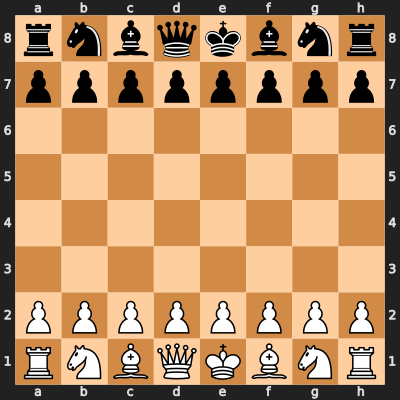


💬 Commentary:
Hi everyone, it's Jerry! We have an excellent game to analyze from Demo Game. This is Player 1 with the white pieces against Player 2. Let's see how this position develops. Chat, starting positions are always full of potential!

📊 Position Analysis:
The game begins with both armies in their starting positions. All pieces are optimally placed for development.


🎯 Move 1: e4
--------------------------------------------------


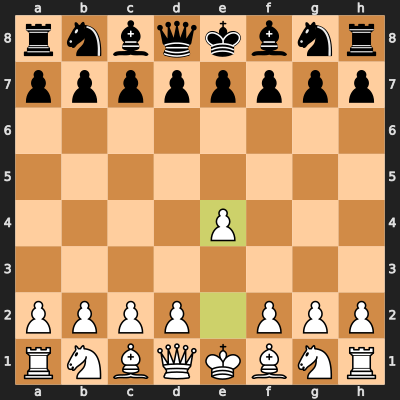


💬 Commentary:
1.e4 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 1: e5
--------------------------------------------------


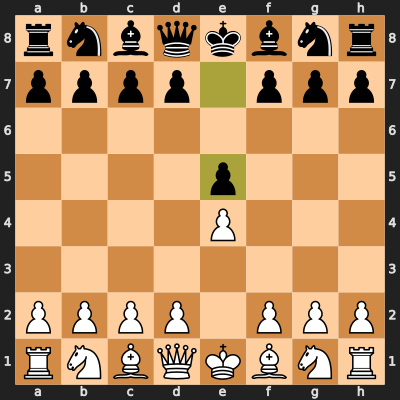


💬 Commentary:
1...e5 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 2: Bc4
--------------------------------------------------


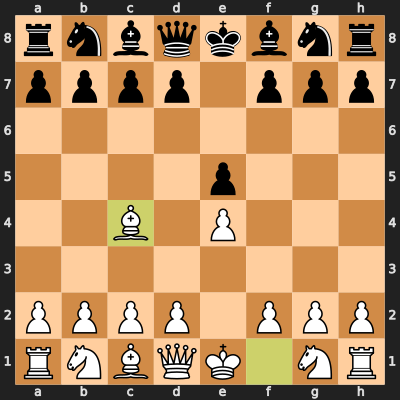


💬 Commentary:
2.Bc4 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 2: Nc6
--------------------------------------------------


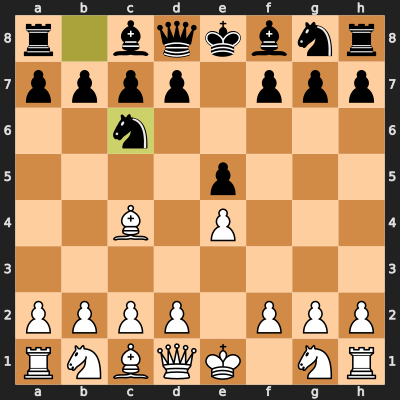


💬 Commentary:
2...Nc6 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 3: Qh5
--------------------------------------------------


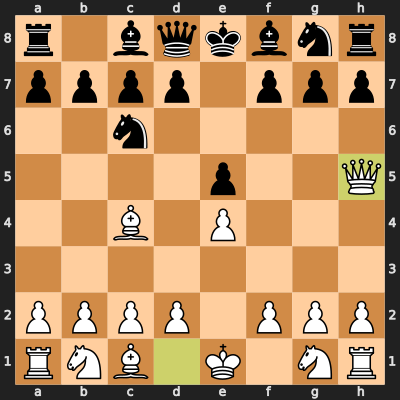


💬 Commentary:
3.Qh5 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 3: Nf6
--------------------------------------------------


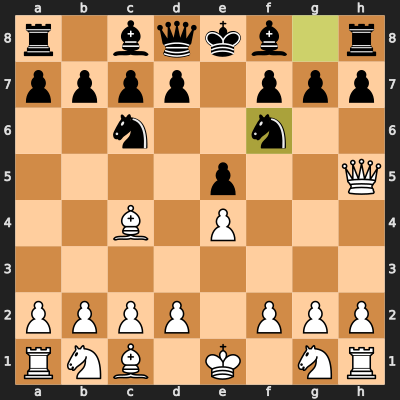


💬 Commentary:
3...Nf6 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 4: Qxf7#
--------------------------------------------------


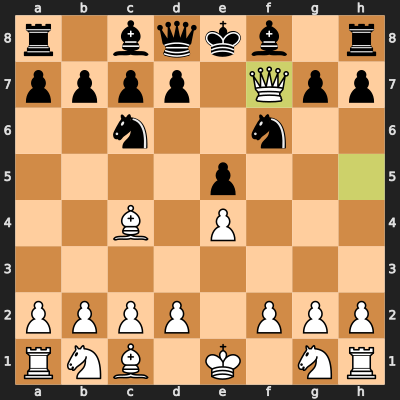


💬 Commentary:
And that's checkmate! 4.Qxf7# ends the game. Chat, that was beautiful execution by White. Like, you don't see sacrificial attacks like this often. Absolute mastery of tactical motifs and king safety principles.

📊 Position Analysis:
Material advantage: White is up by 1 points. Black is in check and must respond to the immediate threat. We're still in the opening/early middlegame phase with many pieces on the board. 

🎬 GAME SUMMARY
Final result: Player 1 wins!
Total moves analyzed: 7
As always, hope you enjoyed this analysis and learned something new!
That's all for now. Take care! 👋

💡 TIP: Use your own PGN by replacing 'demo_pgn' above!
💡 OPTIONS:
   - show_all_moves=True: Shows every single move
   - key_moves_only=True: Shows only critical moves (default)
   - show_all_moves=False, key_moves_only=False: Shows strategic overview


In [2]:
# 🎬 NEW: Visual Commentary with Chess Boards!

# Example game - Scholar's Mate (quick demonstration)
demo_pgn = """
[Event "Demo Game"]
[Site "Notebook"]
[Date "2024.01.01"]
[White "Player 1"]
[Black "Player 2"] 
[Result "1-0"]

1. e4 e5 2. Bc4 Nc6 3. Qh5 Nf6 4. Qxf7# 1-0
"""

print("🎯 VISUAL COMMENTARY DEMO - Scholar's Mate")
print("=" * 60)
print("This will show chess boards synchronized with commentary!")
print("\n📺 Generating visual commentary...")

# Generate visual commentary with boards
generate_visual_commentary(demo_pgn, show_all_moves=True)

print("\n" + "="*60)
print("💡 TIP: Use your own PGN by replacing 'demo_pgn' above!")
print("💡 OPTIONS:")
print("   - show_all_moves=True: Shows every single move")
print("   - key_moves_only=True: Shows only critical moves (default)")
print("   - show_all_moves=False, key_moves_only=False: Shows strategic overview")

🎯 THE IMMORTAL GAME - Visual Commentary
Adolf Anderssen vs Lionel Kieseritzky, London 1851
🔄 Parsing game...
🎬 VISUAL CHESS COMMENTARY
📋 Anderssen, Adolf vs Kieseritzky, Lionel
🏆 Event: London | Date: 1851.06.21 | Result: 1-0

🎯 Move 0: Starting Position
--------------------------------------------------


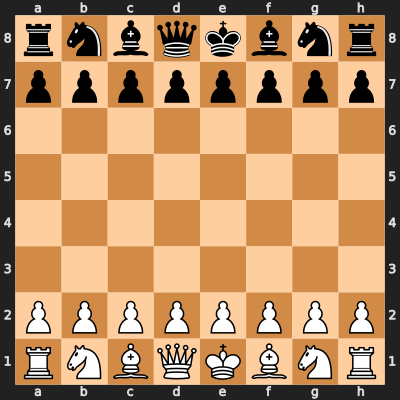


💬 Commentary:
Hi everyone, it's Jerry! We have an excellent game to analyze from London. This is Anderssen, Adolf with the white pieces against Kieseritzky, Lionel. Let's see how this position develops. Chat, starting positions are always full of potential!

📊 Position Analysis:
The game begins with both armies in their starting positions. All pieces are optimally placed for development.


🎯 Move 2: f4
--------------------------------------------------


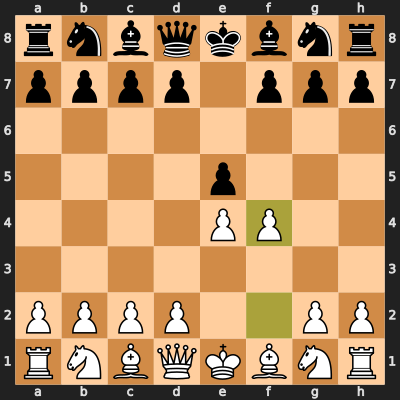


💬 Commentary:
2.f4 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 3: Qh4+
--------------------------------------------------


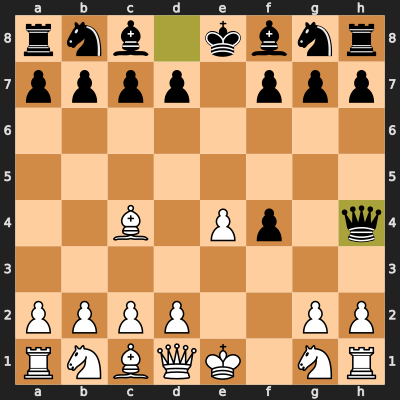


💬 Commentary:
3...Qh4+ gives check! This move puts immediate pressure on White's king. Chat, this is getting spicy. Black is really turning up the heat here.

📊 Position Analysis:
Material advantage: Black is up by 1 points. White is in check and must respond to the immediate threat. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 5: Bxb5
--------------------------------------------------


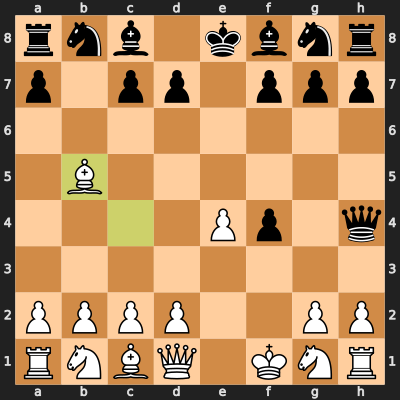


💬 Commentary:
5.Bxb5 captures the pawn! This is a significant material gain for White. The position is opening up, and tactics are in the air.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 6: Qh6
--------------------------------------------------


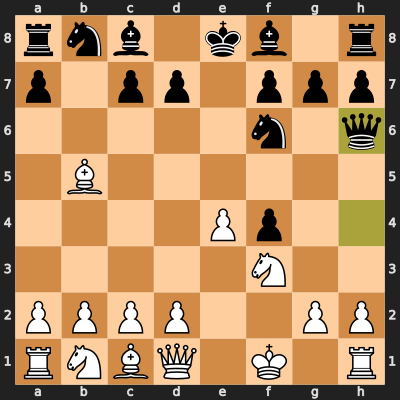


💬 Commentary:
6...Qh6 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 8: Nh4
--------------------------------------------------


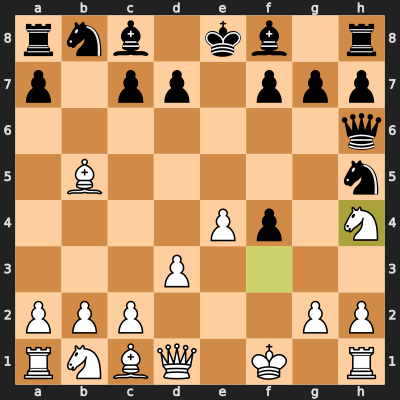


💬 Commentary:
8.Nh4 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 9: c6
--------------------------------------------------


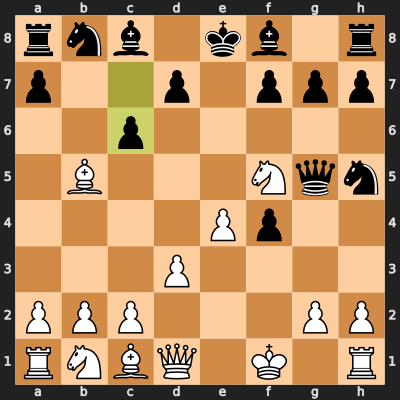


💬 Commentary:
9...c6 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 11: Rg1
--------------------------------------------------


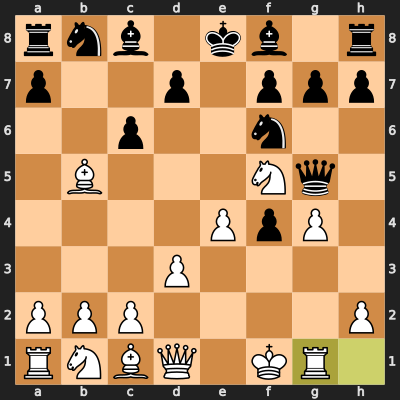


💬 Commentary:
11.Rg1 - entering the middlegame with interesting possibilities. Now we see White implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 12: Qg6
--------------------------------------------------


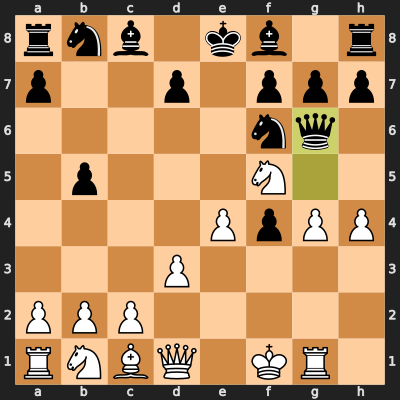


💬 Commentary:
12...Qg6 - entering the middlegame with interesting possibilities. Now we see Black implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material advantage: Black is up by 3 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 14: Qf3
--------------------------------------------------


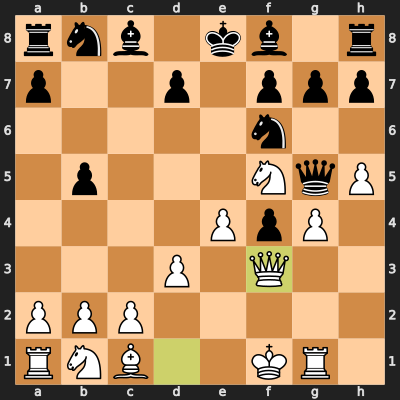


💬 Commentary:
14.Qf3 - entering the middlegame with interesting possibilities. Now we see White implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material advantage: Black is up by 3 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 15: Qf6
--------------------------------------------------


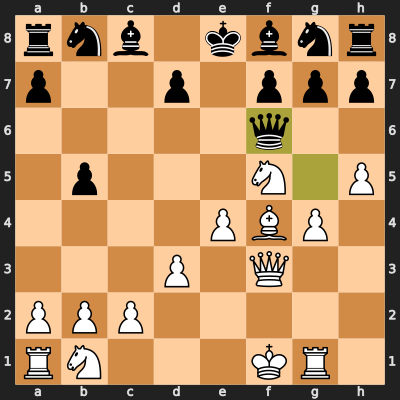


💬 Commentary:
15...Qf6 - entering the middlegame with interesting possibilities. Now we see Black implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material advantage: Black is up by 2 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 17: Nd5
--------------------------------------------------


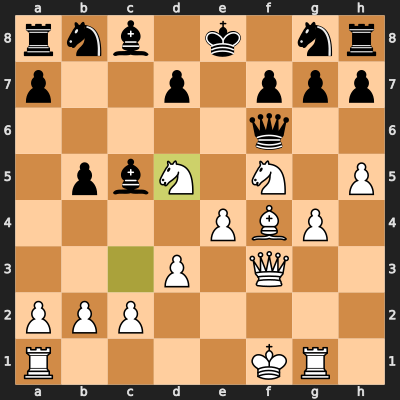


💬 Commentary:
17.Nd5 - entering the middlegame with interesting possibilities. Now we see White implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material advantage: Black is up by 2 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 18: Bxg1
--------------------------------------------------


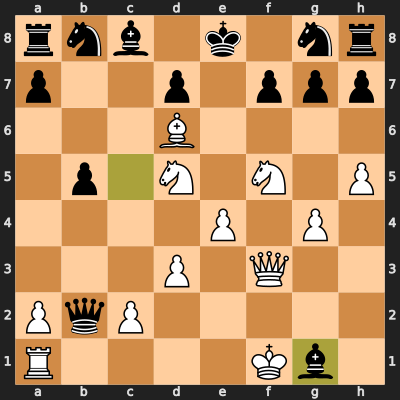


💬 Commentary:
18...Bxg1 captures the rook! This is a significant material gain for Black. The position is opening up, and tactics are in the air.

📊 Position Analysis:
Material advantage: Black is up by 8 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 19: Qxa1+
--------------------------------------------------


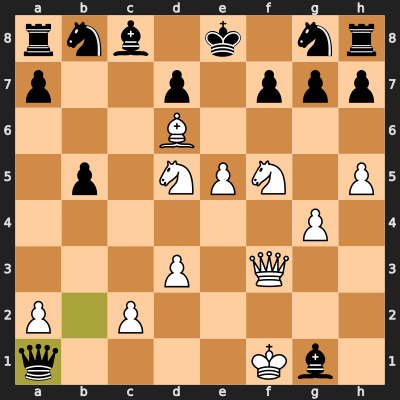


💬 Commentary:
19...Qxa1+ gives check! This move puts immediate pressure on White's king. Chat, this is getting spicy. Black is really turning up the heat here.

📊 Position Analysis:
Material advantage: Black is up by 13 points. White is in check and must respond to the immediate threat. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 20: Ke2
--------------------------------------------------


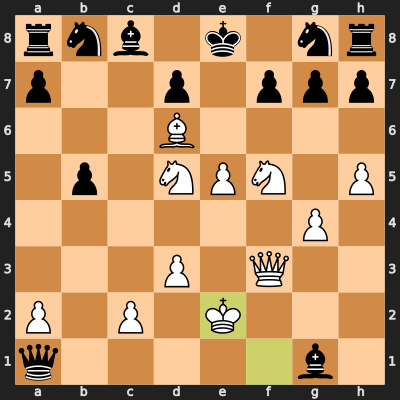


💬 Commentary:
20.Ke2 - entering the middlegame with interesting possibilities. Now we see White implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material advantage: Black is up by 13 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 21: Nxg7+
--------------------------------------------------


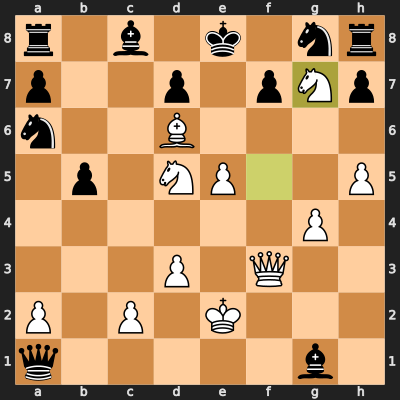


💬 Commentary:
21.Nxg7+ gives check! This move puts immediate pressure on Black's king. Chat, this is getting spicy. White is really turning up the heat here.

📊 Position Analysis:
Material advantage: Black is up by 12 points. Black is in check and must respond to the immediate threat. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 21: Kd8
--------------------------------------------------


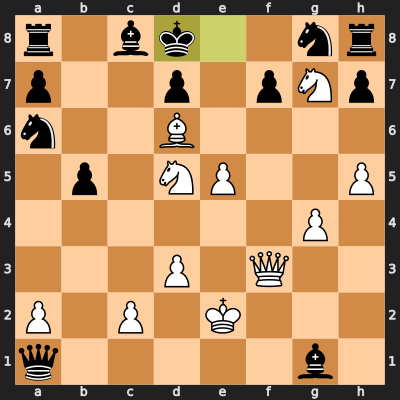


💬 Commentary:
21...Kd8 - entering the middlegame with interesting possibilities. Now we see Black implementing their strategic plan. The pawn structure suggests both sides have chances.

📊 Position Analysis:
Material advantage: Black is up by 12 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 22: Qf6+
--------------------------------------------------


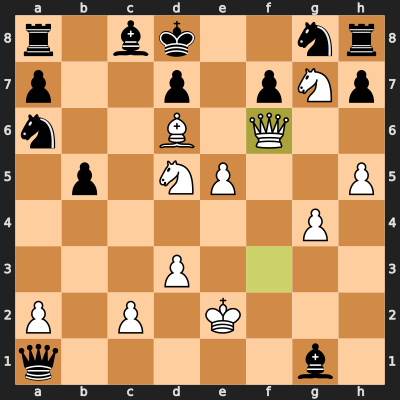


💬 Commentary:
22.Qf6+ gives check! This move puts immediate pressure on Black's king. Chat, this is getting spicy. White is really turning up the heat here.

📊 Position Analysis:
Material advantage: Black is up by 12 points. Black is in check and must respond to the immediate threat. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 22: Nxf6
--------------------------------------------------


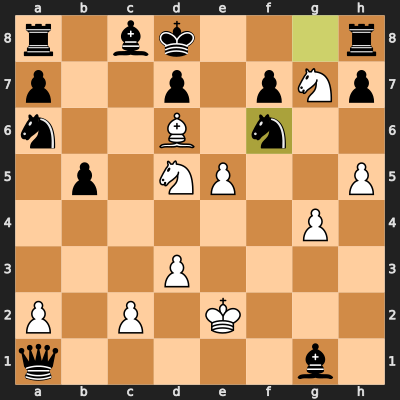


💬 Commentary:
22...Nxf6 captures the queen! This is a significant material gain for Black. The position is opening up, and tactics are in the air.

📊 Position Analysis:
Material advantage: Black is up by 21 points. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 23: Be7#
--------------------------------------------------


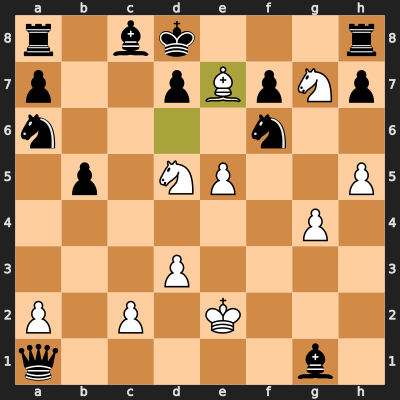


💬 Commentary:
And that's checkmate! 23.Be7# ends the game. Chat, that was beautiful execution by White. Like, you don't see sacrificial attacks like this often. Absolute mastery of tactical motifs and king safety principles.

📊 Position Analysis:
Material advantage: Black is up by 21 points. Black is in check and must respond to the immediate threat. We're still in the opening/early middlegame phase with many pieces on the board. 

🎬 GAME SUMMARY
Final result: Anderssen, Adolf wins!
Total moves analyzed: 45
As always, hope you enjoyed this analysis and learned something new!
That's all for now. Take care! 👋

📚 Historical Note:
This game is called 'The Immortal Game' due to Anderssen's brilliant
sacrificial attack culminating in a beautiful checkmate pattern.


In [3]:
# 🏆 Visual Commentary - Famous Game Example

# The Immortal Game with visual boards
immortal_game_pgn = """
[Event "London"]
[Site "London"]
[Date "1851.06.21"]
[Round "?"]
[White "Anderssen, Adolf"]
[Black "Kieseritzky, Lionel"]
[Result "1-0"]

1. e4 e5 2. f4 exf4 3. Bc4 Qh4+ 4. Kf1 b5 5. Bxb5 Nf6 6. Nf3 Qh6 7. d3 Nh5 
8. Nh4 Qg5 9. Nf5 c6 10. g4 Nf6 11. Rg1 cxb5 12. h4 Qg6 13. h5 Qg5 14. Qf3 Ng8 
15. Bxf4 Qf6 16. Nc3 Bc5 17. Nd5 Qxb2 18. Bd6 Bxg1 19. e5 Qxa1+ 20. Ke2 Na6 
21. Nxg7+ Kd8 22. Qf6+ Nxf6 23. Be7# 1-0
"""

print("🎯 THE IMMORTAL GAME - Visual Commentary")
print("Adolf Anderssen vs Lionel Kieseritzky, London 1851")
print("=" * 60)

# Show key moves only (to keep output manageable)
generate_visual_commentary(immortal_game_pgn, key_moves_only=True)

print("\n📚 Historical Note:")
print("This game is called 'The Immortal Game' due to Anderssen's brilliant")
print("sacrificial attack culminating in a beautiful checkmate pattern.")

## 📚 Visual Chess Commentary - Usage Guide

### 🎯 NEW FEATURES:

✅ **Visual Chess Boards** - See the actual position after each move  
✅ **Synchronized Commentary** - Commentary matches the exact board position  
✅ **Move-by-Move Analysis** - Detailed breakdown of each position  
✅ **Multiple Display Options** - Choose how many moves to show  
✅ **Chess Network + Hikaru Style** - Authentic commentary mixing both styles  

### 🎬 How to Use:

#### **1. Basic Usage (Key Moves Only):**
```python
your_pgn = "[Event...] 1. e4 e5 2. Nf3..."
generate_visual_commentary(your_pgn)
```

#### **2. Show Every Single Move:**
```python
generate_visual_commentary(your_pgn, show_all_moves=True)
```

#### **3. Strategic Overview (First/Middle/Last positions):**
```python
generate_visual_commentary(your_pgn, show_all_moves=False, key_moves_only=False)
```

### 🎨 What You'll See:

- **🎯 Move Header**: Move number and notation
- **♟️ Visual Board**: SVG chess board (or ASCII fallback)  
- **💬 Commentary**: Jerry + Hikaru style analysis
- **📊 Position Analysis**: Material count, king safety, game phase
- **🎬 Final Summary**: Game result and key insights

### 💡 Pro Tips:

- Use `key_moves_only=True` for longer games to avoid information overload
- Use `show_all_moves=True` for short tactical games like Scholar's Mate  
- The boards highlight the last move played for easy visualization
- Commentary adapts based on move type (captures, checks, checkmates, etc.)

### 🔧 Technical Features:

- **Smart Move Selection**: Automatically identifies critical moves
- **Board Highlighting**: Last move is highlighted on each board
- **Responsive Commentary**: Different commentary styles for opening/middlegame/endgame
- **Error Handling**: Graceful fallback to ASCII boards if SVG fails

🎮 YOUR CHESS GAME - Visual Commentary
📝 Paste your PGN above and run this cell!

🎬 Generating visual commentary for your game...
🔄 Parsing game...
🎬 VISUAL CHESS COMMENTARY
📋 You vs Opponent
🏆 Event: Your Game Here | Date: 2024.01.01 | Result: *

🎯 Move 0: Starting Position
--------------------------------------------------


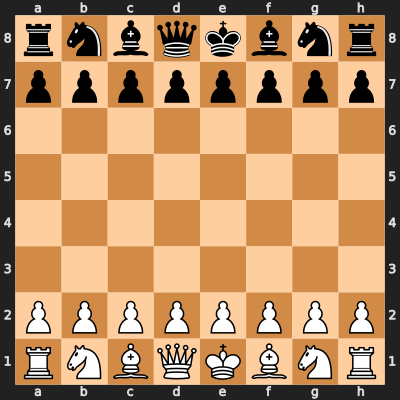


💬 Commentary:
Hi everyone, it's Jerry! We have an excellent game to analyze from Your Game Here. This is You with the white pieces against Opponent. Let's see how this position develops. Chat, starting positions are always full of potential!

📊 Position Analysis:
The game begins with both armies in their starting positions. All pieces are optimally placed for development.


🎯 Move 2: Nf3
--------------------------------------------------


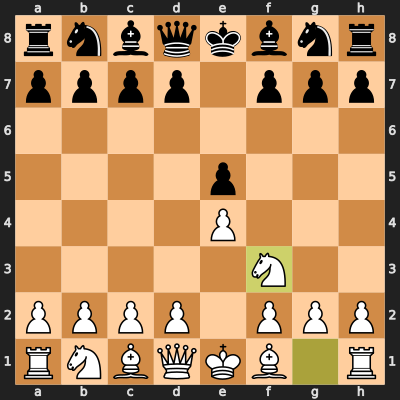


💬 Commentary:
2.Nf3 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 3: a6
--------------------------------------------------


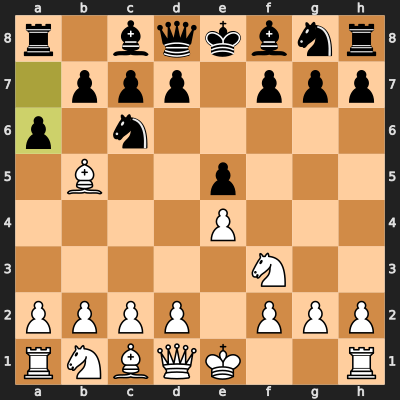


💬 Commentary:
3...a6 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 5: O-O
--------------------------------------------------


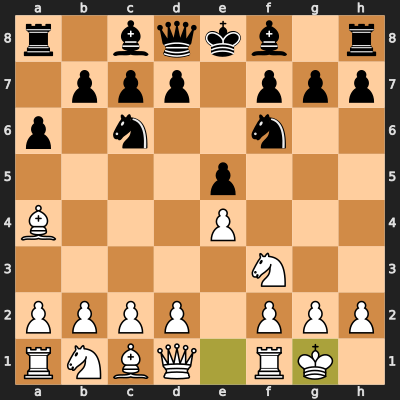


💬 Commentary:
5.O-O - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 6: b5
--------------------------------------------------


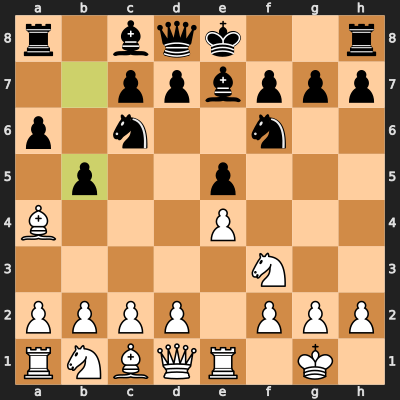


💬 Commentary:
6...b5 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 8: c3
--------------------------------------------------


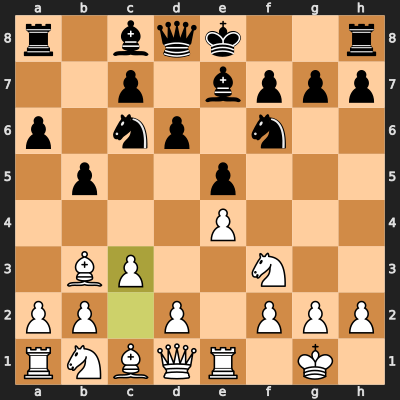


💬 Commentary:
8.c3 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 9: Nb8
--------------------------------------------------


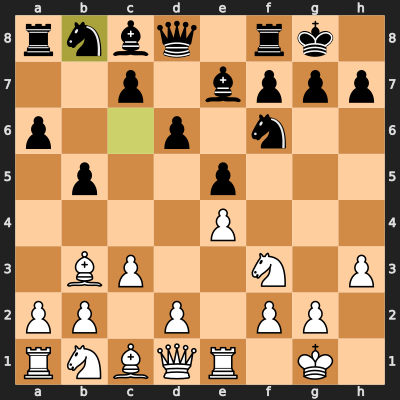


💬 Commentary:
9...Nb8 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 10: d4
--------------------------------------------------


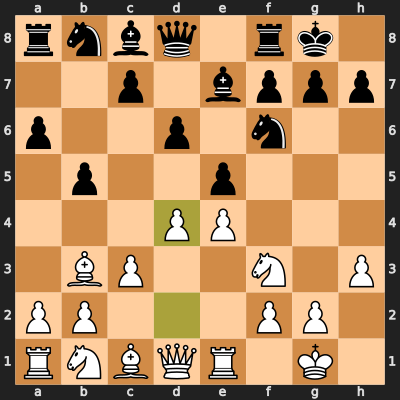


💬 Commentary:
10.d4 - continuing with solid opening development. White is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 


🎯 Move 10: Nbd7
--------------------------------------------------


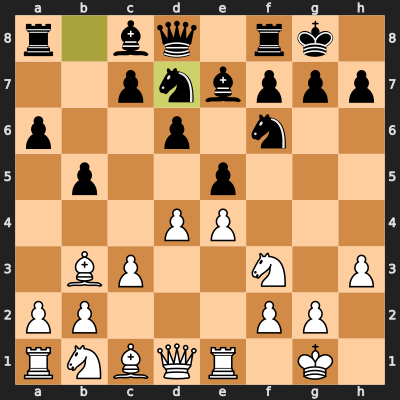


💬 Commentary:
10...Nbd7 - continuing with solid opening development. Black is following classical principles here, getting pieces into active squares. Chat, this is textbook opening play.

📊 Position Analysis:
Material is equal. We're still in the opening/early middlegame phase with many pieces on the board. 

🎬 GAME SUMMARY
Final result: Game result unclear.
Total moves analyzed: 20
As always, hope you enjoyed this analysis and learned something new!
That's all for now. Take care! 👋

🎯 ADVANCED OPTIONS:
Try these variations:

# Show every single move:
# generate_visual_commentary(your_pgn, show_all_moves=True)

# Show strategic overview only:
# generate_visual_commentary(your_pgn, show_all_moves=False, key_moves_only=False)

💡 Experiment with different PGNs to see how the commentary adapts!
🎪 The system automatically detects tactics, sacrifices, and critical moments!


In [4]:
# 🎮 Try It Yourself - Your PGN Here!

# Replace this with your own chess game PGN
your_pgn = """
[Event "Your Game Here"]
[Site "?"]
[Date "2024.01.01"]
[White "You"]
[Black "Opponent"]
[Result "*"]

1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-O Be7 6. Re1 b5 7. Bb3 d6 8. c3 O-O 9. h3 Nb8 10. d4 Nbd7
"""

print("🎮 YOUR CHESS GAME - Visual Commentary")
print("=" * 60)
print("📝 Paste your PGN above and run this cell!")
print("\n🎬 Generating visual commentary for your game...")

# Generate commentary for your game
generate_visual_commentary(your_pgn, key_moves_only=True)

print("\n" + "="*80)
print("🎯 ADVANCED OPTIONS:")
print("Try these variations:")
print()
print("# Show every single move:")
print("# generate_visual_commentary(your_pgn, show_all_moves=True)")
print()
print("# Show strategic overview only:")
print("# generate_visual_commentary(your_pgn, show_all_moves=False, key_moves_only=False)")
print()
print("💡 Experiment with different PGNs to see how the commentary adapts!")
print("🎪 The system automatically detects tactics, sacrifices, and critical moments!")